<a href="https://colab.research.google.com/github/ffatmanurggultekin/scoliosis-detection/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define your data directories
train_dir = '/content/drive/MyDrive/train_imadjust_sobel_diff_alpha0.5'
val_dir = '/content/drive/MyDrive/validation_imadjust_sobel_diff_alpha0.5'
test_dir = '/content/drive/MyDrive/test_imadjust_sobel_diff_alpha0.5'


In [ ]:
# Combine train and validation directories for cross-validation
def gather_paths_and_labels(directory):
    data = []
    for label, class_name in enumerate(['Normal', 'Scol']):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            data.append((os.path.join(class_dir, file), label))
    return np.array(data)

train_data = gather_paths_and_labels(train_dir)
val_data = gather_paths_and_labels(val_dir)
test_data = gather_paths_and_labels(test_dir)

# Merge train and validation data for cross-validation
train_val_data = np.concatenate((train_data, val_data))


In [ ]:
# Model creation function
def create_googlenet_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Cross-validation function
def run_cross_validation(data, n_splits=5, epochs=50, batch_size=32):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data[:, 0], data[:, 1])):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        train_files, val_files = data[train_idx], data[val_idx]

        train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
            pd.DataFrame({'filename': train_files[:, 0], 'class': train_files[:, 1]}),
            x_col='filename', y_col='class',
            target_size=(224, 224), batch_size=batch_size, class_mode='binary', shuffle=True
        )

        val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
            pd.DataFrame({'filename': val_files[:, 0], 'class': val_files[:, 1]}),
            x_col='filename', y_col='class',
            target_size=(224, 224), batch_size=batch_size, class_mode='binary', shuffle=False
        )

        model = create_googlenet_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping], verbose=1)

        val_labels = val_files[:, 1].astype(int)
        val_preds = (model.predict(val_gen) > 0.5).astype(int).ravel()

        accuracy_list.append((val_preds == val_labels).mean())
        precision_list.append(precision_score(val_labels, val_preds))
        recall_list.append(recall_score(val_labels, val_preds))
        f1_list.append(f1_score(val_labels, val_preds))

    print("\n5-Fold Cross-Validation Results:")
    print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
    print(f"Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"F1-Score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")

    return model


In [ ]:
# Run cross-validation
final_model = run_cross_validation(train_val_data)


=== Fold 1/5 ===
Found 171 validated image filenames belonging to 2 classes.
Found 43 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.6879 - loss: 1.6234 - val_accuracy: 0.5349 - val_loss: 0.8671
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6823 - loss: 0.6178 - val_accuracy: 0.7907 - val_loss: 0.4607
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8353 - loss: 0.2962 - val_accuracy: 0.8372 - val_loss: 0.3034
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9186 - loss: 0.1890 - val_accuracy: 0.8605 - val_loss: 0.3291
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9588 - loss: 0.1641 - val_accuracy: 0.8605 - val_loss: 0.2731
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9623 - loss: 0.1262 - val_accuracy: 0.9070 - val_loss: 0.2642
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9771 - loss: 0.0796 - val_accuracy: 0.8837 - val_loss: 0.3093
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9721 - loss: 0.0914 - val_accuracy: 0.9302 - val_loss: 0.2494
Epoch 9/50
6

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6358 - loss: 0.6785 - val_accuracy: 0.7209 - val_loss: 0.5861
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8565 - loss: 0.3802 - val_accuracy: 0.8837 - val_loss: 0.2787
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9099 - loss: 0.2030 - val_accuracy: 0.9070 - val_loss: 0.2878
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8780 - loss: 0.2623 - val_accuracy: 0.9302 - val_loss: 0.1896
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9854 - loss: 0.0823 - val_accuracy: 0.9535 - val_loss: 0.2371
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9595 - loss: 0.0997 - val_accuracy: 0.9535 - val_loss: 0.1755
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9897 - loss: 0.0584 - val_accuracy: 0.8837 - val_loss: 0.1648
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9851 - loss: 0.0902 - val_accuracy: 0.9535 - val_loss: 0.2128
Epoch 9/50
6

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5755 - loss: 0.9218 - val_accuracy: 0.9535 - val_loss: 0.2409
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8845 - loss: 0.3237 - val_accuracy: 0.9535 - val_loss: 0.1692
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9186 - loss: 0.2531 - val_accuracy: 0.9767 - val_loss: 0.1311
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9771 - loss: 0.1467 - val_accuracy: 0.9767 - val_loss: 0.1005
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9403 - loss: 0.1852 - val_accuracy: 1.0000 - val_loss: 0.0919
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9857 - loss: 0.0840 - val_accuracy: 0.9767 - val_loss: 0.0871
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9655 - loss: 0.0858 - val_accuracy: 0.9767 - val_loss: 0.0874
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9746 - loss: 0.0817 - val_accuracy: 0.9535 - val_loss: 0.0780
Epoch 9/50
6

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8062 - loss: 0.4648 - val_accuracy: 0.9767 - val_loss: 0.1524
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9241 - loss: 0.2068 - val_accuracy: 0.8837 - val_loss: 0.3418
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8826 - loss: 0.2921 - val_accuracy: 0.9535 - val_loss: 0.1098
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9439 - loss: 0.1336 - val_accuracy: 0.9535 - val_loss: 0.0888
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9670 - loss: 0.1125 - val_accuracy: 0.9767 - val_loss: 0.0405
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9865 - loss: 0.0654 - val_accuracy: 0.9302 - val_loss: 0.0950
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0291 - val_accuracy: 1.0000 - val_loss: 0.0177
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9962 - loss: 0.0331 - val_accuracy: 0.9302 - val_loss: 0.0729
Epoch 9/50
6

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6823 - loss: 0.7389 - val_accuracy: 0.9524 - val_loss: 0.1714
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8651 - loss: 0.3276 - val_accuracy: 0.9524 - val_loss: 0.1424
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9065 - loss: 0.1869 - val_accuracy: 0.9762 - val_loss: 0.0666
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9178 - loss: 0.2118 - val_accuracy: 0.9762 - val_loss: 0.0683
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9451 - loss: 0.1097 - val_accuracy: 0.9524 - val_loss: 0.0613
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9807 - loss: 0.0669 - val_accuracy: 0.9762 - val_loss: 0.0817
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9554 - loss: 0.0847 - val_accuracy: 0.9524 - val_loss: 0.0509
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9811 - loss: 0.0580 - val_accuracy: 0.9762 - val_loss: 0.0431
Epoch 9/50
6

In [ ]:
# Test set evaluation
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    pd.DataFrame({'filename': test_data[:, 0], 'class': test_data[:, 1]}),
    x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

test_labels = test_data[:, 1].astype(int)
test_preds = (final_model.predict(test_gen) > 0.5).astype(int).ravel()


Found 41 validated image filenames belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step



Test Set Confusion Matrix:
[[12  0]
 [ 4 25]]

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.75      1.00      0.86        12
        Scol       1.00      0.86      0.93        29

    accuracy                           0.90        41
   macro avg       0.88      0.93      0.89        41
weighted avg       0.93      0.90      0.91        41



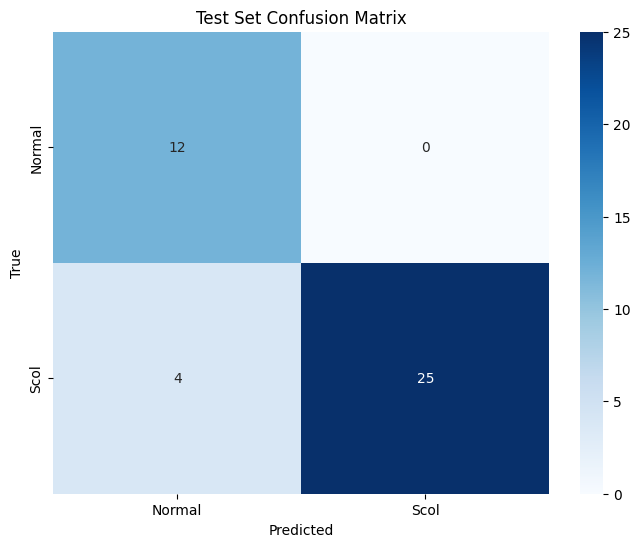

In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(test_labels, test_preds)
print("\nTest Set Confusion Matrix:")
print(cm)
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Normal', 'Scol']))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Scol'], yticklabels=['Normal', 'Scol'])
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
